# Mapping Evaluation

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

bag = rosbag.Bag("stats.bag")
stats = None
for _, msg, _ in bag.read_messages(topics=['stats']):
    stats = msg
bag.close()
if stats is None:
    print "Stats could not be loaded."
else:
    print "Stats loaded successfully."

Stats loaded successfully.


## True Error and Std(True Error) Evoluation of SMAP vs Log Odds

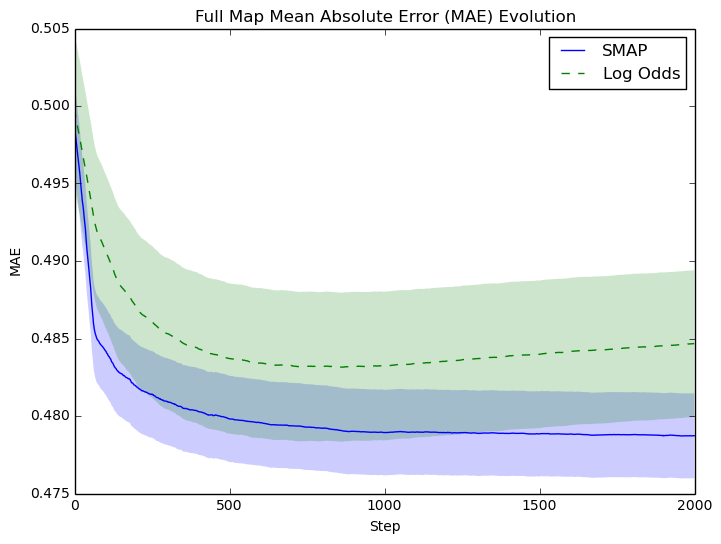

In [60]:
%matplotlib inline
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6))
plt.title("Full Map Mean Absolute Error (MAE) Evolution")

x = list(range(stats.step))
FACTOR = 0.01
errBelief = np.array(stats.errorEvolutionBelief)
stdBelief = np.array(stats.stdEvolutionBelief)
errLogOdds = np.array(stats.errorEvolutionLogOdds)
stdLogOdds = np.array(stats.stdEvolutionLogOdds)

ax.fill_between(x, errBelief - FACTOR*stdBelief, errBelief + FACTOR*stdBelief,
    alpha=0.2, facecolor='b', edgecolor='none', antialiased=True)
ax.fill_between(x, errLogOdds - FACTOR*stdLogOdds, errLogOdds + FACTOR*stdLogOdds,
    alpha=0.2, facecolor='g', edgecolor='none', antialiased=True)


ax.plot(stats.errorEvolutionBelief, label="SMAP", color='b')
ax.plot(stats.errorEvolutionLogOdds, label="Log Odds", linestyle='dashed', color='g')

ax.legend()
ax.set_xlim([0, 2000])
ax.set_xlabel("Step")
ax.set_ylabel("MAE")
plt.savefig("error_evolution.pdf")

The diagram visualizes the full map true error evolution and corresponding standard deviation (multiplied by a factor of 0.1) of log-odds (green) and the proposed method (blue). Note how the estimated standard deviation spans a considerably larger region at log-odds compared to SMAP.

## Correlation between Std and True Absolute Error

(0.5, 1)

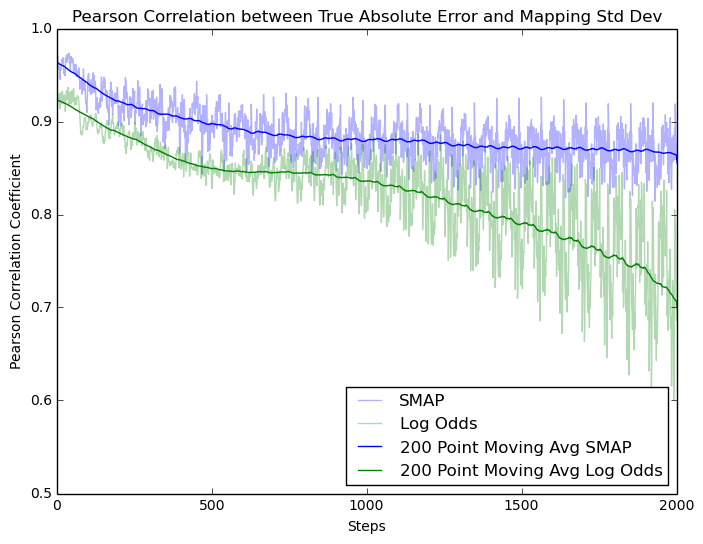

In [57]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6))
plt.title("Pearson Correlation between True Absolute Error and Mapping Std Dev")
plt.xlabel("Steps")
plt.ylabel("Pearson Correlation Coefficient")

ax.plot(np.array(stats.stdErrorCorrelationBelief), alpha=0.3, color="b", label="SMAP")
ax.plot(np.array(stats.stdErrorCorrelationLogOdds), alpha=0.3, color="g", label="Log Odds")
# stats.stdErrorCorrelationLogOdds = np.array(stats.stdErrorCorrelationLogOdds)
# last_finite = 1.
# for i in range(len(stats.stdErrorCorrelationLogOdds)):
#     if np.isfinite(stats.stdErrorCorrelationLogOdds[i]):
#         last_finite = stats.stdErrorCorrelationLogOdds[i]
#     else:
#         stats.stdErrorCorrelationLogOdds[i] = last_finite

# mask = np.isfinite(stats.stdErrorCorrelationLogOdds)

#stats.stdErrorCorrelationLogOdds[~mask] = 0

def moving_avg(array, n=200):
    return np.convolve([array[0]]*(n/2) + list(array) + [array[-1]]*(n/2), np.ones(n) / n)[int(n):]

# smoothedCorrelationLogOdds = np.convolve(stats.stdErrorCorrelationLogOdds, np.ones(100) / 100)
#mask = np.isfinite(smoothedCorrelationLogOdds)
ax.plot(moving_avg(stats.stdErrorCorrelationBelief), color="b", label="200 Point Moving Avg SMAP")
ax.plot(moving_avg(stats.stdErrorCorrelationLogOdds), color="g", label="200 Point Moving Avg Log Odds")
ax.legend(loc="lower right")
ax.set_xlim([0, 2000])#len(stats.stdErrorCorrelationBelief)])
ax.set_ylim([0.5, 1])

This plot shows the Pearson correlation coefficient between the Mean Absolute Error and the mapping standard deviation over all voxels that were updated at a certain step. A correlation coefficient close to 1 represents positive linear correlation, 0 means no linear correlation, and -1 negative linear correlation. The estimated standard deviation of the proposed approach linearly correlates much stronger to the true error compared to log-odds, enabling a more reliable method of estimating the mapping confidence.